# ML4VA Project: Analysis on VA State Government spending and its effects on population and income

---



## Step 2: Load the Data

In [128]:
import pandas as pd
import sklearn
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

income = pd.read_csv('household_income.csv')
population = pd.read_csv('virginia_population.csv')
state_money = pd.read_csv('state_monetary_info.csv')

In [129]:
print(income.head())
print()
print(population.head())
print()
print(state_money.head()[state_money.columns[:4]])

       DATE  MEDIAN_INCOME
0  1/1/1984          26530
1  1/1/1985          28430
2  1/1/1986          29720
3  1/1/1987          30000
4  1/1/1988          32650

        Date  Population  Annual % Change
0  12/1/1900     1858000             0.00
1  12/1/1901     1887000             1.56
2  12/1/1902     1894000             0.37
3  12/1/1903     1890000            -0.21
4  12/1/1904     1889000            -0.05

   Year (R01) Total Revenue (R02) Total Rev-Own Sources (R03) General Revenue
0  1977         $4,098,080                  $3,133,456            $3,576,392 
1  1978         $4,706,668                  $3,546,177            $4,176,167 
2  1979         $5,135,929                  $3,898,404            $4,572,651 
3  1980         $5,655,917                  $4,264,523            $5,034,342 
4  1981         $6,484,377                  $4,903,737            $5,610,949 


In [130]:
income['DATE'] = pd.to_datetime(income['DATE'])
population['Date'] = pd.to_datetime(population['Date'])

income['Year'] = income['DATE'].dt.year - 1 # adjusted pop. to this date - 1 bc previous year measured makes sense
population['Year'] = population['Date'].dt.year # adjusted up bc measured at end of year
merged_data = pd.merge(income, population, on='Year')

income_population = merged_data.drop(columns=['DATE', 'Date'])
income_population = income_population.rename(columns={'Annual % Change': 'Pop. Yearly % Change', 'MEDIAN_INCOME': 'Median_income'})

print(income_population.head())

   Median_income  Year  Population  Pop. Yearly % Change
0          26530  1983     5564657                  1.31
1          28430  1984     5643870                  1.42
2          29720  1985     5715153                  1.26
3          30000  1986     5811700                  1.69
4          32650  1987     5932268                  2.07


In [131]:
# https://www.w3schools.com/python/python_regex.asp
data = pd.merge(state_money, income_population, on='Year')
for col in data.select_dtypes(include='object').columns:
    data[col] = (
        data[col]
        .replace('[\$,]', '', regex=True) # remove $ signs from money values
        .replace(r'\((.*)\)', r'-\1', regex=True) # handle negativevs in ()
        .astype(float) # turn from object type to float
    )

print(data['Year'].head())

0    1983
1    1984
2    1985
3    1986
4    1987
Name: Year, dtype: int64


In [132]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 291 entries, Year to Pop. Yearly % Change
dtypes: float64(288), int64(3)
memory usage: 88.8 KB
None


## Step 3. Discover and visualize the data to gain insights
**Data Discovery:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than others. This information will help you confirm the weights of your regression model later on.

In [133]:
# data.hist(bins=50, figsize=(20,15))
# plt.show()
# too many columns it looks crazy


In [134]:
# Your code to visualize the data here
corr_matrix = data.corr(numeric_only=True)
corr_matrix["Population"].sort_values(ascending=False)

,Population
Population,1.000000
(D44) Total Securities,0.997683
Year,0.996914
(D25) LTD Out-General,0.992787
(D27) LTD Out-Gen-Other NEC,0.992642
...,...
(D36) LTD Out-NG-Utility,NaN
(D37) LTD Out-NG-Water Util (44A),NaN
(D38) LTD Out-NG-Elec Util (44B),NaN
(D39) LTD Out-NG-Gas Util (44C),NaN


In [135]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["Median_income"].sort_values(ascending=False)

,Median_income
Median_income,1.000000
(D61) Nonin Trust-Total Sec,0.993212
(R04) Gen Rev-Own Sources,0.991407
(R27) Individual Income Tax (T40),0.990195
(R26) Total Income Taxes,0.989281
...,...
(D36) LTD Out-NG-Utility,NaN
(D37) LTD Out-NG-Water Util (44A),NaN
(D38) LTD Out-NG-Elec Util (44B),NaN
(D39) LTD Out-NG-Gas Util (44C),NaN


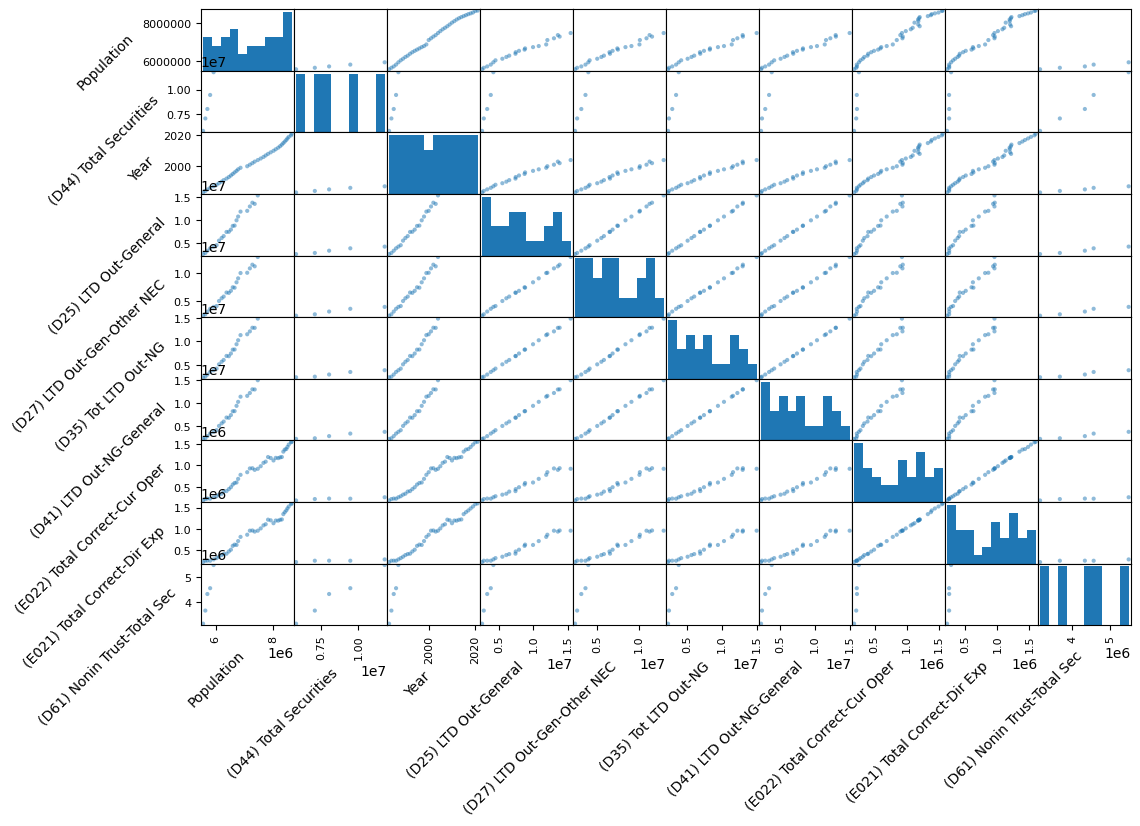

In [136]:
from pandas.plotting import scatter_matrix

top_10_corr = corr_matrix["Population"].sort_values(ascending=False).head(10).reset_index()
top_10_corr.columns = ['Feature', 'Correlation']
attributes = top_10_corr['Feature']
# scatter_matrix(data[attributes], figsize=(12, 8));
axes = scatter_matrix(data[attributes], figsize=(12, 8));

for ax in axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
    ax.set_ylabel(ax.get_ylabel(), rotation=45, ha='right')

plt.show()

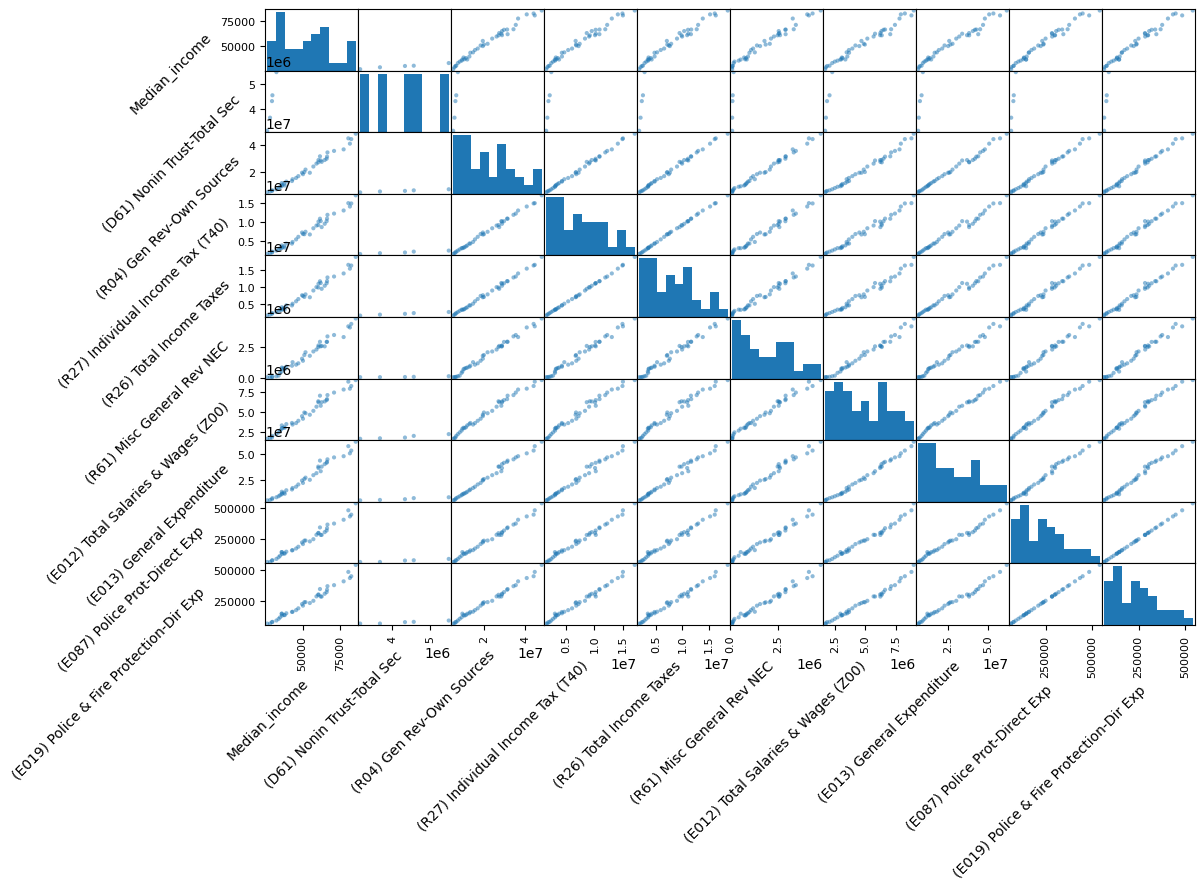

In [137]:
from pandas.plotting import scatter_matrix

top_10_corr = corr_matrix["Median_income"].sort_values(ascending=False).head(10).reset_index()
top_10_corr.columns = ['Feature', 'Correlation']
attributes = top_10_corr['Feature']
# scatter_matrix(data[attributes], figsize=(12, 8));
axes = scatter_matrix(data[attributes], figsize=(12, 8));

for ax in axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
    ax.set_ylabel(ax.get_ylabel(), rotation=45, ha='right')

plt.show()

In [138]:
print(data.iloc[:, :100].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 100 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Year                                    39 non-null     int64  
 1   (R01) Total Revenue                     39 non-null     float64
 2   (R02) Total Rev-Own Sources             39 non-null     float64
 3   (R03) General Revenue                   39 non-null     float64
 4   (R04) Gen Rev-Own Sources               39 non-null     float64
 5   (R05) Total Taxes                       39 non-null     float64
 6   (R06) Property Tax (T01)                39 non-null     float64
 7   (R07) NonProperty Taxes                 39 non-null     float64
 8   (R08) Tot Sales & Gr Rec Tax            39 non-null     float64
 9   (R09) Total Gen Sales Tax (T09)         39 non-null     float64
 10  (R10) Total Select Sales Tax            39 non-null     float64

In [139]:
print(data.iloc[:, 100:200].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 100 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   (E018) General Capital Outlay                39 non-null     float64
 1   (E019) Police & Fire Protection-Dir Exp      39 non-null     float64
 2   (E020) Air Trans-Direct Expend               39 non-null     float64
 3   (E021) Total Correct-Dir Exp                 39 non-null     float64
 4   (E022) Total Correct-Cur Oper                39 non-null     float64
 5   (E023) Total Correct-Cap Out                 39 non-null     float64
 6   (E024) Total Educ-Direct Exp                 39 non-null     float64
 7   (E025) Total Educ-Cur Oper                   39 non-null     float64
 8   (E026) Total Educ-Cap Outlay                 39 non-null     float64
 9   (E027) Elem Educ-Direct Exp                  39 non-null     float64
 10  (E0

In [140]:
print(data.iloc[:, 200:].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 91 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   (E118) Non Water Util-Total Exp       39 non-null     float64
 1   (E119) Non Water Util-Inter Exp       39 non-null     float64
 2   (E120) Non Water Util-Cur Oper        39 non-null     float64
 3   (E121) Non Water Util-Cap Outlay      39 non-null     float64
 4   (E122) Elec Util-Total Exp            39 non-null     float64
 5   (E123) Elec Util-Inter Exp (I92)      39 non-null     float64
 6   (E124) Elec Util-Cur Oper (E92)       39 non-null     float64
 7   (E125) Elec Util-Cap Outlay           39 non-null     float64
 8   (E126) Gas Util-Total Exp             39 non-null     float64
 9   (E127) Gas Util-Inter Exp (I93)       39 non-null     float64
 10  (E128) Gas Util-Cur Oper (E93)        39 non-null     float64
 11  (E129) Gas Util-Cap O

##  Step 4: Data Preparation and Cleaning
* **Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the `Imputer` class.

* **Feature Scaling:** Your task is to call the `StandardScaler` to normalize the value of each feature.

* **Transformation Pipeline:** More importantly, you will need to integrate the above operations into a `Pipeline` to process and transform the training data (via `fit_transform()`), then use the same pipeline to transform any validation and testing data (using `transform()` only).

In [141]:
# Your code check for missing values, feature scaling, and put all transformation into a pipeline here
print(len(data))

print(data.isna().sum().sum())

nas = data.isna().sum()
na_columns1 = nas[nas > 0]
print(na_columns1)
na_columns = nas[nas >= 14]
print(na_columns)

39
1169
(R33) Fed IGR-Gen Rev Shar (B27)      34
(R72) Emp Ret-Employee Ctrib           5
(R73) Emp Ret-From Other Gov (X05)     5
(R74) Emp Ret-From Admin Govt         15
(R79) Lottery-Ticket Sales (Z51)      15
                                      ..
(D60) Nonin Trust-Cash & Dep          34
(D61) Nonin Trust-Total Sec           34
(D62) Nonin Trust-Sec-Tot Fed         34
(D63) Nonin Trust-Sec-St & Loc        34
(D64) Nonin Trust-Sec-Other           34
Length: 63, dtype: int64
(R33) Fed IGR-Gen Rev Shar (B27)       34
(R74) Emp Ret-From Admin Govt          15
(R79) Lottery-Ticket Sales (Z51)       15
(R80) Lottery-Prizes Awarded (Z52)     15
(R81) Lottery-Admin Exp (Z53)          15
(R82) Lottery-Net Proceeds (Z54)       15
(E061) Own Hospital-Total Exp          17
(E062) Own Hospital-Cur Oper (E36)     17
(E063) Own Hospital-Cap Out            17
(E064) Hosp-Other-Direct Exp           17
(D07) LTD Iss-Utility                  17
(D08) LTD Iss-Util-Water               17
(D09) LTD Is

In [142]:
col_data = data.drop(columns=na_columns1.index)
print(col_data.isna().sum().sum())

0


In [143]:
data_corr = data

In [144]:
# import seaborn as sns

# # Correlation heatmap
# plt.figure(figsize=(16, 12))
# corr_matrix = data.corr(numeric_only=True)
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
# plt.title('Correlation Heatmap')
# plt.show()

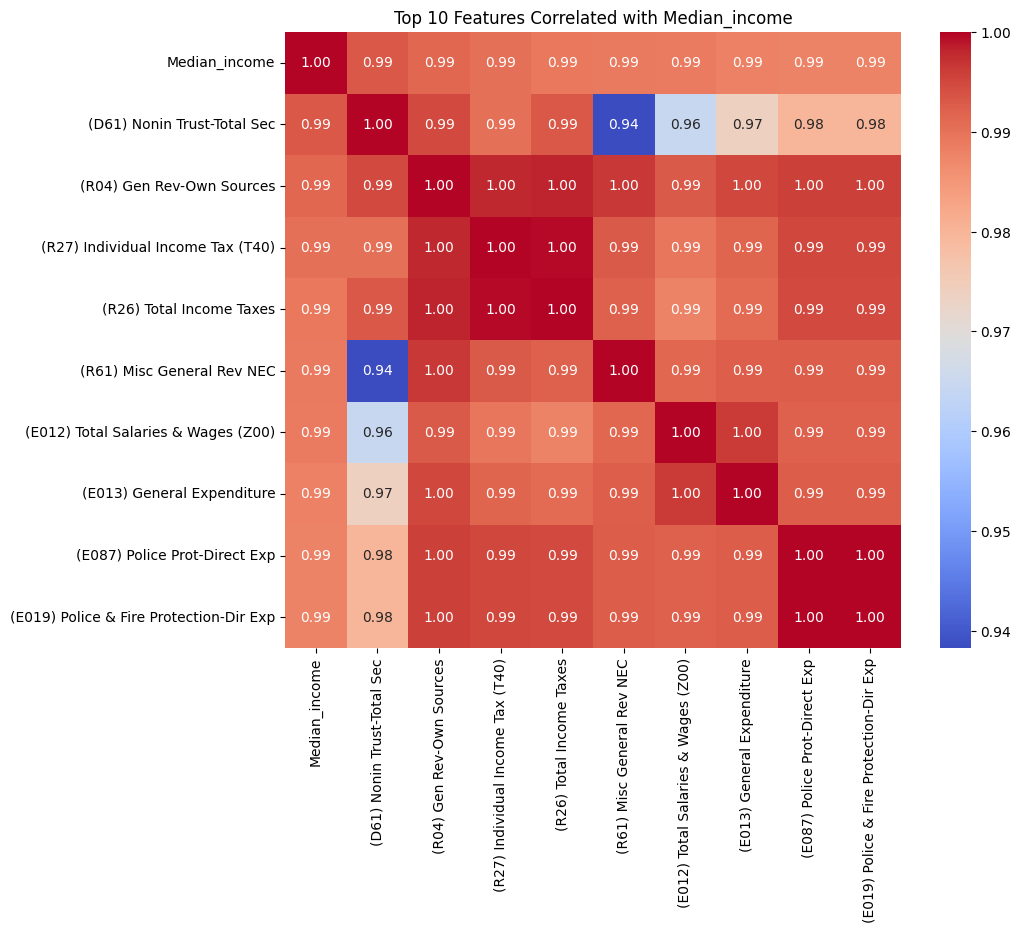

In [145]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr(numeric_only=True)

# Select the target variable (e.g., Median_income)
target = "Median_income"

# Find top 10 correlated features with the target
top_10_features = corr_matrix[target].sort_values(ascending=False).head(10).index

# Subset the correlation matrix for the top 10 features
subset_corr = corr_matrix.loc[top_10_features, top_10_features]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title(f"Top 10 Features Correlated with {target}")
plt.show()


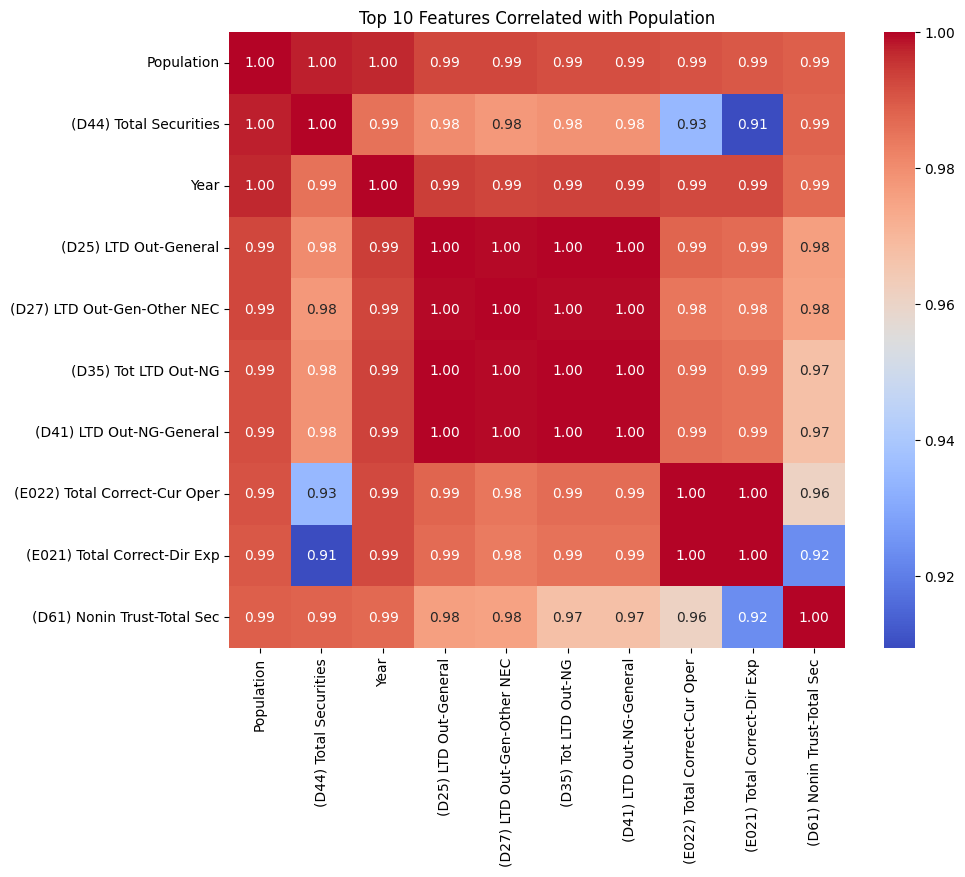

In [146]:
target = "Population"

# Find top 10 correlated features with the target
top_10_features = corr_matrix[target].sort_values(ascending=False).head(10).index

# Subset the correlation matrix for the top 10 features
subset_corr = corr_matrix.loc[top_10_features, top_10_features]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title(f"Top 10 Features Correlated with {target}")
plt.show()

In [147]:
data = col_data
data.describe()

,Year,(R01) Total Revenue,(R02) Total Rev-Own Sources,(R03) General Revenue,(R04) Gen Rev-Own Sources,(R05) Total Taxes,(R06) Property Tax (T01),(R07) NonProperty Taxes,(R08) Tot Sales & Gr Rec Tax,(R09) Total Gen Sales Tax (T09),...,(D56) Unemp Comp-Bal In US Trs (Y07),(D57) Unemp Comp-Other Balance (Y08),(D58) Other Insur Trusts-Cash & Sec,(D59) Nonin Trust-Cash & Sec,(D65) Sinking Fd-Cash & Sec,(D66) Bond Fd-Cash & Sec,(D67) Oth Nonin Fd-Cash & Sec,Median_income,Population,Pop. Yearly % Change
count,39.000000,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01,39.000000,3.900000e+01,3.900000e+01,3.900000e+01,...,3.900000e+01,3.900000e+01,39.000000,3.900000e+01,3.900000e+01,3.900000e+01,3.900000e+01,39.000000,3.900000e+01,39.000000
mean,2002.000000,3.301486e+07,2.651060e+07,2.795338e+07,2.144913e+07,1.382233e+07,26006.282051,1.379632e+07,4.862315e+06,2.757114e+06,...,6.346709e+05,1.819145e+05,2602.692308,1.896000e+07,8.990224e+06,3.886746e+05,9.581101e+06,52321.794872,7.232489e+06,1.174103
std,11.401754,2.068932e+07,1.608841e+07,1.677929e+07,1.218231e+07,7.285146e+06,7710.431737,7.280422e+06,2.331893e+06,1.378600e+06,...,3.488299e+05,4.069425e+05,2290.781666,1.101311e+07,4.049439e+06,2.106748e+05,7.401426e+06,16735.959217,9.822879e+05,0.521121
min,1983.000000,7.539780e+06,6.115917e+06,6.270367e+06,4.846504e+06,3.553236e+06,15318.000000,3.517371e+06,1.516281e+06,7.215800e+05,...,4.404500e+04,-1.228140e+05,0.000000,3.523556e+06,2.076639e+06,7.935300e+04,1.078790e+06,26530.000000,5.564657e+06,0.230000
25%,1992.500000,1.579931e+07,1.299484e+07,1.352963e+07,1.072516e+07,7.298572e+06,19846.500000,7.283237e+06,2.935304e+06,1.618308e+06,...,3.634550e+05,1.003500e+03,0.000000,9.734082e+06,5.810727e+06,2.518640e+05,3.358614e+06,37040.000000,6.424055e+06,0.955000
50%,2002.000000,2.619404e+07,2.213734e+07,2.484298e+07,1.933616e+07,1.296918e+07,23575.000000,1.294914e+07,4.762982e+06,2.692151e+06,...,6.192450e+05,2.344000e+03,2880.000000,1.716880e+07,8.569580e+06,3.913790e+05,8.462035e+06,51140.000000,7.286873e+06,1.130000
75%,2011.500000,4.900708e+07,4.031825e+07,3.931654e+07,2.916821e+07,1.849478e+07,32244.500000,1.847337e+07,6.026180e+06,3.568638e+06,...,8.335410e+05,4.333000e+04,4354.000000,2.772482e+07,1.310311e+07,4.908805e+05,1.390058e+07,63625.000000,8.144946e+06,1.335000
max,2021.000000,9.774775e+07,7.363588e+07,7.218767e+07,4.807580e+07,3.232810e+07,43332.000000,3.228477e+07,1.171939e+07,6.527477e+06,...,1.470804e+06,1.470804e+06,6299.000000,5.195424e+07,1.433059e+07,1.155934e+06,3.730822e+07,85170.000000,8.657348e+06,3.390000


In [148]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.15)
data_income = train_set["Median_income"].copy()
data_population = train_set["Population"].copy()
# data = train_set.drop("Median_income", axis=1)
# data = train_set.drop("Population", axis=1)
data = train_set.drop(columns=['Median_income', 'Population'])

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

data_prepared = pipe.fit_transform(data)
data_prepared

array([[ 0.91932179,  0.99064104,  0.97949987, ...,  0.64910903,
         0.55465272, -0.43162754],
       [ 1.01383151,  0.5976649 ,  0.52455684, ...,  0.79067978,
         0.64933336, -0.30077982],
       [-1.06538226, -0.92039488, -0.92501388, ..., -0.86087243,
        -1.00239194,  0.57776914],
       ...,
       [-0.02577538, -0.44992431, -0.49185751, ..., -1.40715684,
         0.00269671,  0.16653346],
       [-0.49832396, -0.5822266 , -0.57282881, ...,  0.01817086,
        -0.6448839 , -0.45032007],
       [ 1.4863801 ,  1.39626771,  1.48613049, ...,  0.12367287,
         0.74338502, -1.08586612]])

In [150]:
X_test = test_set.drop(columns=['Median_income', 'Population'])
y_test_pop = test_set[['Population']]
y_test_inc = test_set[['Median_income']]

X_test_prepared = pipe.transform(X_test)

## Step 5: Model Selection
You must use 5-fold CV on the data set to evaluate the performance of your models (following the sample codes on Colab 02).


In [151]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

data_labels = pd.DataFrame({'Median_income': data_income, 'Population': data_population})

In [152]:
def display_scores(scores):
  print('Scores:', scores)
  print('Mean:', scores.mean())
  print('Standard deviation:', scores.std())

  # Try a few models here

### Linear Regression

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(data_prepared, pd.DataFrame({'Median_income': data_income, 'Population': data_population}))

# print('Predictions:', lin_reg.predict(data_prepared))

from sklearn.metrics import mean_squared_error

data_pred = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_pred)
lin_rmse = np.sqrt(lin_mse)
print('Mean squared error:', lin_rmse)

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(data_labels, data_pred)
print('Mean absolute error:', lin_mae)

lin_scores = cross_val_score(lin_reg, data_prepared, data_labels, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Mean squared error: 2.1569879858642995e-09
Mean absolute error: 1.3104440630272484e-09
Scores: [ 45376.97481027 193701.09355771  48920.99221683  64909.21930094
  69155.21674212]
Mean: 84412.69932557471
Standard deviation: 55390.574439380754


In [154]:
print('Predictions:', lin_reg.predict(data_prepared))

Predictions: [[  64630.         8102437.        ]
 [  65910.         8187456.        ]
 [  36140.         6213526.        ]
 [  66160.         8255861.        ]
 [  54780.         7286873.        ]
 [  45690.         6789225.        ]
 [  81310.         8510919.99999999]
 [  36220.         6536771.        ]
 [  32650.         5932268.        ]
 [  51140.         7366977.        ]
 [  66450.         8367303.        ]
 [  39210.         6601392.        ]
 [  85170.         8657347.99999999]
 [  60370.         7925937.        ]
 [  37650.         6464795.        ]
 [  34120.         6036909.        ]
 [  30000.         5811700.        ]
 [  36430.         6383315.        ]
 [  47160.         6872912.        ]
 [  50240.         7105817.        ]
 [  60500.         7833496.        ]
 [  26530.         5564657.        ]
 [  51910.         7475575.        ]
 [  28430.         5643870.        ]
 [  35070.         6120246.        ]
 [  61490.         8315430.        ]
 [  61990.         775100

In [155]:
# # Ensure the years are available in the dataset
# years = train_set['Year']  # Adjust based on your dataset's structure

# # Median Income: Plot actual values as scatter points and predicted values as a line
# plt.figure(figsize=(12, 6))
# plt.scatter(years, data_income, alpha=0.6, color='blue', label="Actual Median Income")
# plt.plot(years, income_pred, color='red', label="Predicted Median Income", linewidth=2)
# plt.title("Actual vs Predicted: Median Income Over Time")
# plt.xlabel("Year")
# plt.ylabel("Median Income")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Population: Plot actual values as scatter points and predicted values as a line
# plt.figure(figsize=(12, 6))
# plt.scatter(years, data_population, alpha=0.6, color='green', label="Actual Population")
# plt.plot(years, pop_pred, color='orange', label="Predicted Population", linewidth=2)
# plt.title("Actual vs Predicted: Population Over Time")
# plt.xlabel("Year")
# plt.ylabel("Population")
# plt.legend()
# plt.grid(True)
# plt.show()


In [156]:
# # Residuals
# residual_median_income = data_income - pred_median_income
# residual_population = data_population - pred_population

# plt.figure(figsize=(12, 6))
# plt.scatter(pred_median_income, residual_median_income, alpha=0.6, color='blue')
# plt.axhline(0, color='red', linestyle='--')
# plt.title("Residual Plot: Median Income")
# plt.xlabel("Predicted Median Income")
# plt.ylabel("Residuals")
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(pred_population, residual_population, alpha=0.6, color='green')
# plt.axhline(0, color='red', linestyle='--')
# plt.title("Residual Plot: Population")
# plt.xlabel("Predicted Population")
# plt.ylabel("Residuals")
# plt.grid(True)
# plt.show()


In [157]:
# metrics = {
#     'Metric': ['RMSE', 'MAE'],
#     'Median Income': [lin_rmse, lin_mae],
#     'Population': [
#         np.sqrt(mean_squared_error(data_population, pred_population)),
#         mean_absolute_error(data_population, pred_population)
#     ]
# }

# metrics_df = pd.DataFrame(metrics)
# metrics_df.set_index('Metric', inplace=True)

# metrics_df.plot(kind='bar', figsize=(10, 6), title="Model Performance Metrics", rot=0)
# plt.ylabel("Value")
# plt.grid(axis='y')
# plt.show()


In [158]:
# from sklearn.metrics import mean_squared_error

# data_pred = lin_reg.predict(data_prepared)
# lin_mse = mean_squared_error(data_labels, data_pred)
# lin_rmse = np.sqrt(lin_mse)
# print('Mean squared error:', lin_rmse)

# from sklearn.metrics import mean_absolute_error

# lin_mae = mean_absolute_error(data_labels, data_pred)
# print('Mean absolute error:', lin_mae)

# lin_scores = cross_val_score(lin_reg, data_prepared, data_labels, scoring='neg_mean_squared_error', cv=5)
# lin_rmse_scores = np.sqrt(-lin_scores)
# display_scores(lin_rmse_scores)

In [159]:
# lin_scores = cross_val_score(lin_reg, data_prepared, data_labels, scoring='neg_mean_squared_error', cv=5)
# lin_rmse_scores = np.sqrt(-lin_scores)
# display_scores(lin_rmse_scores)

### Decision Tree Regressor

In [160]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(
    # max_depth=5,
    # min_samples_split=10,
    # min_samples_leaf=5,
    # max_features="sqrt",
    # ccp_alpha=0.01,
    random_state=42)
tree_reg.fit(data_prepared, data_labels)

DecisionTreeRegressor(random_state=42)

In [161]:
# Overfitting
data_pred = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_labels, data_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [162]:
scores = cross_val_score(tree_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 80410.44932852  95392.90665303 214599.67319257 213077.04828614
 413510.15475872]
Mean: 203398.04644379637
Standard deviation: 119295.69719351878


In [163]:
# def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
#     x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
#     y_pred = tree_reg.predict(x1)
#     plt.axis(axes)
#     plt.xlabel("$x_1$", fontsize=18)
#     if ylabel:
#         plt.ylabel(ylabel, fontsize=18, rotation=0)
#     plt.plot(X, y, "b.")
#     plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

# plt.figure(figsize=(11, 4))
# plt.subplot(121)
# plot_regression_predictions(tree_reg, data_prepared, data_labels)
# for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
#     plt.plot([split, split], [-0.2, 1], style, linewidth=2)
# plt.text(0.21, 0.65, "Depth=0", fontsize=15)
# plt.text(0.01, 0.2, "Depth=1", fontsize=13)
# plt.text(0.65, 0.8, "Depth=1", fontsize=13)
# plt.legend(loc="upper center", fontsize=18)
# plt.title("max_depth=2", fontsize=14)

# plt.show()

### Random Forest Regressor

In [164]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_labels)

predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_labels, predictions) # this is the combined rmse, the average of both
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

forest_scores = cross_val_score(forest_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE: 22206.56495375242
Scores: [ 44867.58317119  82775.77343408  42159.20404873 164390.56932121
  63448.20938006]
Mean: 79528.2678710544
Standard deviation: 44874.34629204637


### GBoosting

In [165]:
# from sklearn.ensemble import GradientBoostingRegressor

# gbrt_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)
# gbrt_reg.fit(data_prepared, data_labels)

# scores = cross_val_score(gbrt_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=5)
# pd.Series(np.sqrt(-scores)).describe()

## Step 6: Model Tuning

In this step, you should attempt to use one of the provided tools for hyperparameter tuning: `GridSearchCV`, `RandomizedSearchCV` to identify the best set of hyperparameters for your model. After tweaking your models, you eventually should report the 5-fold CV RMSE of your tuned model.

In [166]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_income)

predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_income, predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

forest_scores = cross_val_score(forest_reg, data_prepared, data_income, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE: 1054.7739591251209
Scores: [3633.90739052 4004.6174144   849.84648866 3551.58703634 2915.78004515]
Mean: 2991.1476750113493
Standard deviation: 1126.5171363598042


In [167]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_population)

predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_population, predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

forest_scores = cross_val_score(forest_reg, data_prepared, data_population, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE: 31386.572066022145
Scores: [ 63639.75276686 116968.98399747  59608.8901202  232453.5462573
  89685.61143204]
Mean: 112471.35691477451
Standard deviation: 63425.72122612294


In [168]:
print(data_labels["Median_income"].mean())

50976.36363636364


In [169]:
print(data_labels["Population"].mean())

7178166.2727272725


### RandomizedSearchCV

In [170]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=50),
        'max_depth': randint(low=1, high=50),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_pop = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_pop.fit(data_prepared, data_population)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae1c82f910>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae1907d720>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae19ddae30>},
                   random_state=42, scoring='neg_mean_squared_error')

In [171]:
best_params_pop = rnd_search_pop.best_params_
best_params_pop

{'max_depth': 21, 'max_features': 33, 'n_estimators': 58}

In [172]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=50),
        'max_depth': randint(low=1, high=50),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_inc = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_inc.fit(data_prepared, data_income)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae19095450>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae189a41f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae189a5450>},
                   random_state=42, scoring='neg_mean_squared_error')

In [173]:
best_params_inc = rnd_search_inc.best_params_
best_params_inc

{'max_depth': 47, 'max_features': 44, 'n_estimators': 55}

### GridSearchCV

In [174]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [best_params_pop['n_estimators'] - 2, best_params_pop['n_estimators'], best_params_pop['n_estimators'] + 2],
        'max_features': [best_params_pop['max_features'] - 1, best_params_pop['max_features'], best_params_pop['max_features'] + 1],
        'max_depth': [best_params_pop['max_depth'] - 2, best_params_pop['max_depth'], best_params_pop['max_depth'] + 2],
    }
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(data_prepared, data_income)

print('Best estimator:', grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best estimator: RandomForestRegressor(max_depth=19, max_features=33, n_estimators=56,
                      random_state=42)
3183.9515342732257 {'max_depth': 19, 'max_features': 32, 'n_estimators': 56}
3299.250682283631 {'max_depth': 19, 'max_features': 32, 'n_estimators': 58}
3321.379083115418 {'max_depth': 19, 'max_features': 32, 'n_estimators': 60}
3115.2963648293794 {'max_depth': 19, 'max_features': 33, 'n_estimators': 56}
3251.539416549318 {'max_depth': 19, 'max_features': 33, 'n_estimators': 58}
3255.327883541853 {'max_depth': 19, 'max_features': 33, 'n_estimators': 60}
3156.5516605739567 {'max_depth': 19, 'max_features': 34, 'n_estimators': 56}
3244.856178798378 {'max_depth': 19, 'max_features': 34, 'n_estimators': 58}
3292.5746765705476 {'max_depth': 19, 'max_features': 34, 'n_estimators': 60}
3183.9515342732257 {'max_depth': 21, 'max_features': 32, 'n_estimators': 56}
3299.250682283631 {'max_depth': 21, 'max_features': 32, 'n_estimators': 58}
3321.379083115418 {'max_depth': 21

In [175]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [176]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test_inc, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE for Income: {final_rmse}")

Final RMSE for Income: 2620.415773599796


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [best_params_pop['n_estimators'] - 2, best_params_pop['n_estimators'], best_params_pop['n_estimators'] + 2],
        'max_features': [best_params_pop['max_features'] - 1, best_params_pop['max_features'], best_params_pop['max_features'] + 1],
        'max_depth': [best_params_pop['max_depth'] - 2, best_params_pop['max_depth'], best_params_pop['max_depth'] + 2],
    }
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search_pop = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_pop.fit(data_prepared, data_population)

print('Best estimator:', grid_search_pop.best_estimator_)

cvres = grid_search_pop.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best estimator: RandomForestRegressor(max_depth=41, max_features=8, n_estimators=191,
                      random_state=42)
127128.91337577431 {'max_depth': 41, 'max_features': 7, 'n_estimators': 187}
126887.80899990373 {'max_depth': 41, 'max_features': 7, 'n_estimators': 189}
126640.62695710661 {'max_depth': 41, 'max_features': 7, 'n_estimators': 191}
118087.61422020853 {'max_depth': 41, 'max_features': 8, 'n_estimators': 187}
117842.7645302606 {'max_depth': 41, 'max_features': 8, 'n_estimators': 189}
117706.64162051759 {'max_depth': 41, 'max_features': 8, 'n_estimators': 191}
124834.44208677576 {'max_depth': 41, 'max_features': 9, 'n_estimators': 187}
124359.6309729395 {'max_depth': 41, 'max_features': 9, 'n_estimators': 189}
123974.60609804343 {'max_depth': 41, 'max_features': 9, 'n_estimators': 191}
127128.91337577431 {'max_depth': 43, 'max_features': 7, 'n_estimators': 187}
126887.80899990373 {'max_depth': 43, 'max_features': 7, 'n_estimators': 189}
126640.62695710661 {'max_depth

In [51]:
feature_importances_pop = grid_search_pop.best_estimator_.feature_importances_

In [52]:
final_model = grid_search_pop.best_estimator_

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test_pop, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE for Population: {final_rmse}")

Final RMSE for Population: 101731.16782697666


In [53]:
best_forest = rnd_search_pop.best_estimator_
final_predictions = best_forest.predict(X_test_prepared)
lin_mae = mean_absolute_error(y_test_pop, final_predictions)
print('Mean absolute error for Pop:', lin_mae)

Mean absolute error for Pop: 75030.33421516744


In [54]:
print(f"Final RMSE for Population: {final_rmse}")
print('Mean absolute error for Pop:', lin_mae)

Final RMSE for Population: 101731.16782697666
Mean absolute error for Pop: 75030.33421516744


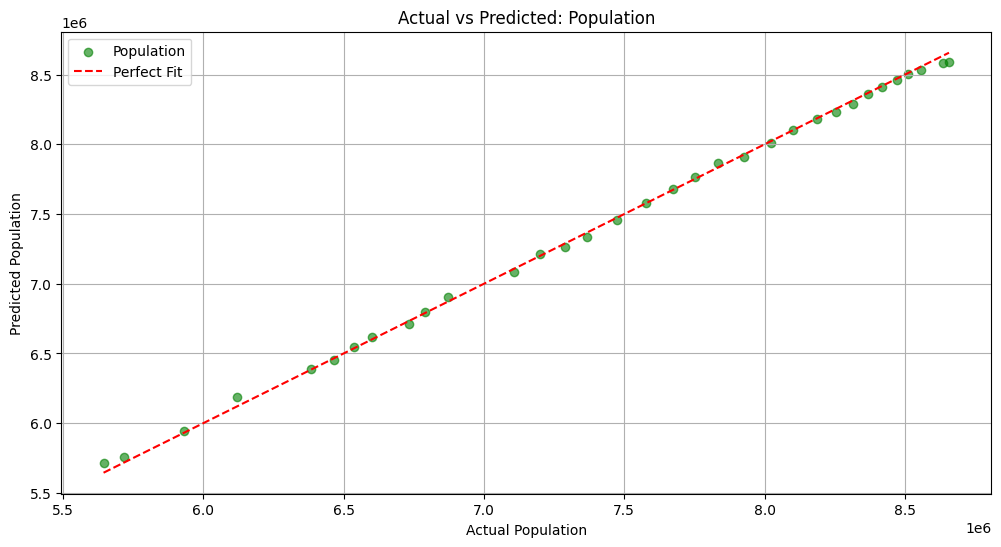

In [55]:
# Predictions and actual values
data_pred = rnd_search_pop.predict(data_prepared)

plt.figure(figsize=(12, 6))
plt.scatter(data_population, data_pred, alpha=0.6, color='green', label="Population")
plt.plot([data_population.min(), data_population.max()], [data_population.min(), data_population.max()], 'r--', label="Perfect Fit")
plt.title("Actual vs Predicted: Population")
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.legend()
plt.grid(True)
plt.show()

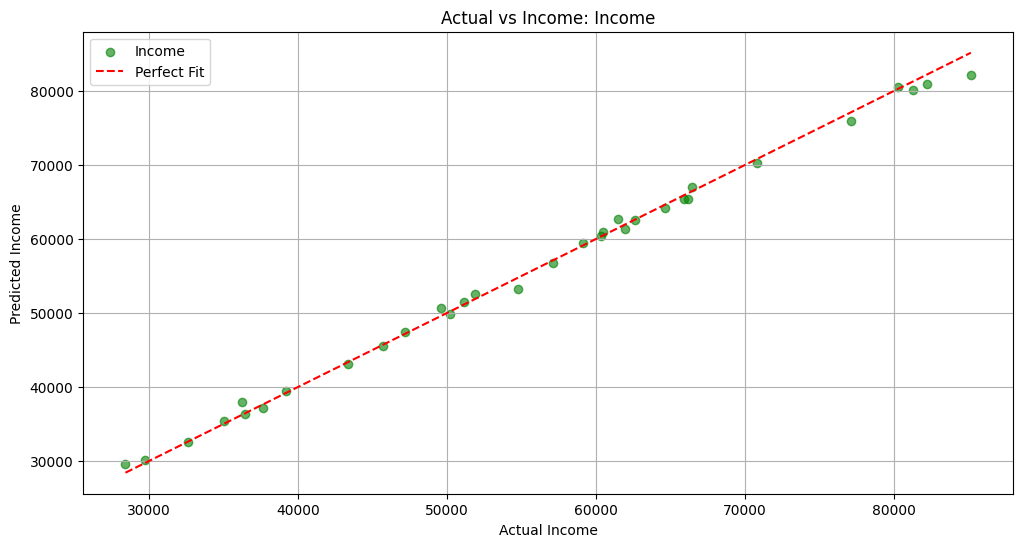

In [56]:
# Predictions and actual values
data_pred = rnd_search_inc.predict(data_prepared)

plt.figure(figsize=(12, 6))
plt.scatter(data_income, data_pred, alpha=0.6, color='green', label="Income")
plt.plot([data_income.min(), data_income.max()], [data_income.min(), data_income.max()], 'r--', label="Perfect Fit")
plt.title("Actual vs Income: Income")
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")
plt.legend()
plt.grid(True)
plt.show()

### Plots for the Video (Potentially)

### Correlation Adjusted Models

In [57]:
# data_income = data_corr["Median_income"].copy()
# data_population = data_corr["Population"].copy()

# data_corr_pop = data_corr.drop(columns=['Median_income'])
# data_corr_inc = data_corr.drop(columns=['Population'])

corr_matrix = data_corr.corr(numeric_only=True)

high_corr_features_pop = corr_matrix["Population"][corr_matrix["Population"].abs() >= 0.8].index

high_corr_features_inc = corr_matrix["Median_income"][corr_matrix["Median_income"].abs() >= 0.8].index

common_features = high_corr_features_pop.intersection(high_corr_features_inc)

filtered_data = data_corr[common_features]

print(filtered_data.head(2))

   Year  (R01) Total Revenue  (R02) Total Rev-Own Sources  \
0  1983            7539780.0                    6115917.0   
1  1984            8170554.0                    6640611.0   

   (R03) General Revenue  (R04) Gen Rev-Own Sources  (R05) Total Taxes  \
0              6270367.0                  4846504.0          3553236.0   
1              7034907.0                  5504964.0          4064368.0   

   (R07) NonProperty Taxes  (R08) Tot Sales & Gr Rec Tax  \
0                3517371.0                     1516281.0   
1                4033021.0                     1696025.0   

   (R09) Total Gen Sales Tax (T09)  (R10) Total Select Sales Tax  ...  \
0                         721580.0                      794701.0  ...   
1                         832982.0                      863043.0  ...   

   (D54) Emp Retire-Sec-Tot Nong  (D58) Other Insur Trusts-Cash & Sec  \
0                      1897767.0                                  0.0   
1                      2598002.0              

In [58]:
train_set, test_set = train_test_split(filtered_data, test_size=0.15)
data_income = train_set["Median_income"].copy()
data_population = train_set["Population"].copy()

In [59]:
pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

data_prepared = pipe.fit_transform(train_set)
data_prepared

array([[-0.24216634, -0.25257993, -0.17325744, ..., -0.20292573,
        -0.29708501, -0.3445916 ],
       [-1.58904652, -1.1541444 , -1.19660055, ..., -1.05881659,
        -1.50049912, -1.61053272],
       [ 1.10471385,  1.01216847,  1.07891939, ...,  0.5381481 ,
         0.98860846,  1.171596  ],
       ...,
       [ 0.56596178,  0.79299848,  0.9911626 , ...,  0.84385195,
         0.72669631,  0.64967782],
       [-1.22987847, -0.97547334, -1.00622126, ..., -0.96128724,
        -1.11611006, -1.23050165],
       [-1.05029445, -0.88160362, -0.89286591, ..., -0.85510332,
        -0.96411308, -1.03617265]])

In [60]:
X_test = test_set
y_test_pop = test_set[['Population']]
y_test_inc = test_set[['Median_income']]

X_test_prepared = pipe.transform(X_test)

### Income

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_income)

predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_income, predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

forest_scores = cross_val_score(forest_reg, data_prepared, data_income, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE: 868.697915203431
Scores: [3241.15643163 3594.07040992 1916.44536764 1907.04278487 3754.28770097]
Mean: 2882.600539005184
Standard deviation: 809.9085084739212


In [62]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=50),
        'max_depth': randint(low=1, high=50),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_inc = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_inc.fit(data_prepared, data_income)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae17918c40>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae179bb490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae1807fc10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [63]:
best_params_inc = rnd_search_inc.best_params_
best_params_inc
print('Best parameters:', best_params_inc)

Best parameters: {'max_depth': 21, 'max_features': 39, 'n_estimators': 122}


In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [best_params_inc['n_estimators'] - 2, best_params_inc['n_estimators'], best_params_inc['n_estimators'] + 2],
        'max_features': [best_params_inc['max_features'] - 1, best_params_inc['max_features'], best_params_inc['max_features'] + 1],
        'max_depth': [best_params_inc['max_depth'] - 2, best_params_inc['max_depth'], best_params_inc['max_depth'] + 2],
    }
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(data_prepared, data_income)

print('Best estimator:', grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best estimator: RandomForestRegressor(max_depth=19, max_features=39, n_estimators=122,
                      random_state=42)
2761.348986910787 {'max_depth': 19, 'max_features': 38, 'n_estimators': 120}
2760.8779239699493 {'max_depth': 19, 'max_features': 38, 'n_estimators': 122}
2750.050032006774 {'max_depth': 19, 'max_features': 38, 'n_estimators': 124}
2672.068295619524 {'max_depth': 19, 'max_features': 39, 'n_estimators': 120}
2657.2602306624062 {'max_depth': 19, 'max_features': 39, 'n_estimators': 122}
2659.194752630087 {'max_depth': 19, 'max_features': 39, 'n_estimators': 124}
2899.7680667322256 {'max_depth': 19, 'max_features': 40, 'n_estimators': 120}
2886.5987243228687 {'max_depth': 19, 'max_features': 40, 'n_estimators': 122}
2868.468654464714 {'max_depth': 19, 'max_features': 40, 'n_estimators': 124}
2761.348986910787 {'max_depth': 21, 'max_features': 38, 'n_estimators': 120}
2760.8779239699493 {'max_depth': 21, 'max_features': 38, 'n_estimators': 122}
2750.050032006774 {'ma

In [65]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test_inc, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE for Income: {final_rmse}")

Final RMSE for Income: 2236.835658291754


### Population

In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(data_prepared, data_population)

predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_population, predictions)
forest_rmse = np.sqrt(forest_mse)
print('RMSE:', forest_rmse)

forest_scores = cross_val_score(forest_reg, data_prepared, data_population, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

RMSE: 26995.16074087943
Scores: [191816.496625    60008.45466248  53323.64557157  98839.22089535
 119886.35208725]
Mean: 104774.83396832953
Standard deviation: 49982.18487429847


In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=50),
        'max_depth': randint(low=1, high=50),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search_inc = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_inc.fit(data_prepared, data_population)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae1807de40>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae17f64820>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78ae17f64760>},
                   random_state=42, scoring='neg_mean_squared_error')

In [68]:
best_params_pop = rnd_search_pop.best_params_
best_params_pop
print('Best parameters:', best_params_pop)

Best parameters: {'max_depth': 43, 'max_features': 8, 'n_estimators': 189}


In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [best_params_pop['n_estimators'] - 2, best_params_pop['n_estimators'], best_params_pop['n_estimators'] + 2],
        'max_features': [best_params_pop['max_features'] - 1, best_params_pop['max_features'], best_params_pop['max_features'] + 1],
        'max_depth': [best_params_pop['max_depth'] - 2, best_params_pop['max_depth'], best_params_pop['max_depth'] + 2],
    }
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(data_prepared, data_population)

print('Best estimator:', grid_search.best_estimator_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best estimator: RandomForestRegressor(max_depth=41, max_features=9, n_estimators=187,
                      random_state=42)
115691.69929019647 {'max_depth': 41, 'max_features': 7, 'n_estimators': 187}
115770.15820826567 {'max_depth': 41, 'max_features': 7, 'n_estimators': 189}
115478.70595658549 {'max_depth': 41, 'max_features': 7, 'n_estimators': 191}
113630.1694121247 {'max_depth': 41, 'max_features': 8, 'n_estimators': 187}
113792.08349540942 {'max_depth': 41, 'max_features': 8, 'n_estimators': 189}
113666.21434151985 {'max_depth': 41, 'max_features': 8, 'n_estimators': 191}
112066.63909817144 {'max_depth': 41, 'max_features': 9, 'n_estimators': 187}
112257.984154004 {'max_depth': 41, 'max_features': 9, 'n_estimators': 189}
112261.33740790297 {'max_depth': 41, 'max_features': 9, 'n_estimators': 191}
115691.69929019647 {'max_depth': 43, 'max_features': 7, 'n_estimators': 187}
115770.15820826567 {'max_depth': 43, 'max_features': 7, 'n_estimators': 189}
115478.70595658549 {'max_depth'

In [70]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test_pop, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE for Population: {final_rmse}")

Final RMSE for Population: 49669.99153815882
